In [1]:
dogs = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

cats=['n02123045','n02123159','n02123394','n02123597','n02124075','n02125311','n02127052']

## 文件操作

In [2]:
import os
import shutil 
import random
import time
print('File operation begin !')
t=time.time()
TRAIN_PATH = "./train/"
TEST_PATH = "./test/"
# SAMPLE_PATH = "sample/"
CAT_PATH = "cat/"
DOG_PATH = "dog/"
CLEAN_TRAIN = "clean_train/"

def checkDir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

checkDir(CAT_PATH)
checkDir(DOG_PATH)
checkDir(CLEAN_TRAIN)

if len(os.listdir(CAT_PATH)) == 0:
    train_files = os.listdir(TRAIN_PATH)
    for file in train_files:
        if 'dog' in file:
            shutil.copy(TRAIN_PATH + file, DOG_PATH + file)
        if 'cat' in file:
            shutil.copy(TRAIN_PATH + file, CAT_PATH + file)    

t2 = time.time()
print('File done', round(t2 - t, 2), 'seconds to operation !')

File operation begin !
File done 0.06 seconds to operation !


In [3]:
import cv2
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as plb
from keras.models import Model
from keras.layers import Input, Flatten, Dropout, Dense
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications import Xception, InceptionResNetV2, DenseNet201
import json as js
from tqdm import *


Using TensorFlow backend.


###  数据可视化

In [24]:
imgs = []
for file in train_files:
    img = cv2.imread(TRAIN_PATH + file)
    imgs.append(img.shape[0:2])
#     break
    
imgs = np.array(imgs)
x = imgs[:,0]
y = imgs[:,1]

Populating the interactive namespace from numpy and matplotlib


/Users/leezhe/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


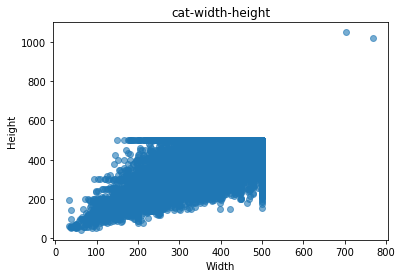

In [25]:
%pylab inline
plt.title('cat-width-height')
plt.xlabel('Width')
plt.ylabel('Height')
plt.scatter(x, y, alpha = 0.6)
plt.show()

### 数据预处理
- 加载ImageNet猫狗的预测结果对比数据

- 结合 Xception，InceptionResNetV2， DenseNet201 完成异常值检测

In [107]:
from PIL import Image
subplots_adjust(left=0.0,bottom=0.0,top=0.1,right=0.1,hspace = 0)
def showImge(doc, files, size = (12,12)):
    fig = plt.figure(num= 'astronaut',figsize=size)
    row = int(len(files) / 5 if len(files) % 5 == 0 else len(files) / 5 + 1)
    print(row)
    for idx,file in enumerate(files):
        img = Image.open(doc + file)    
        plt.axis('on') # 关掉坐标轴为 off
        plt.title(file)
        plt.subplot(row,5,idx + 1)
        plt.tight_layout()
        fig.set_size_inches(20.5, 10.5,forward=True)
        plt.imshow(img)
    plt.show()
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [143]:
def process_outliers(files,model,preprocess_input, target_size=(299, 299),top = 50):
    outlier_files = []
    np_cats = np.array(cats)
    np_dogs = np.array(dogs)
    for file in tqdm(files):
        img = image.load_img(TRAIN_PATH + file, target_size=target_size)
    #     print("file:", file)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        preds = model.predict(x)
        pred = decode_predictions(preds, top= top)[0]
        # 取交集
        if 'dog' in file:
            intersections = np.intersect1d(np.array(pred)[:,0],np_dogs)
        else:
            intersections = np.intersect1d(np.array(pred)[:,0],np_cats)

        if len(intersections) == 0:
            outlier_files.append(file)
    return outlier_files

In [ ]:
# Xception 
from keras.applications.xception import preprocess_input as pre_x
model = Xception(include_top=True,weights='imagenet')
train_files = os.listdir(TRAIN_PATH)
outliers = process_outliers(train_files[:1000],model,pre_x)


 28%|██▊       | 282/1000 [03:14<08:15,  1.45it/s]

In [ ]:
# showImge(T,not_cats,size=(12, 12))

1


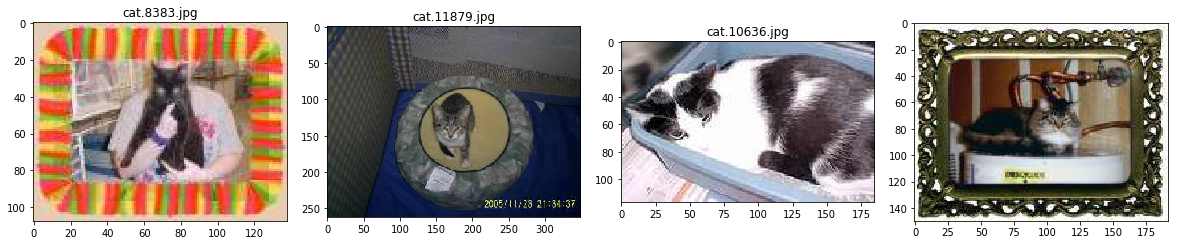

In [129]:
# InceptionResNetV2
from keras.appl
model = InceptionResNetV2(weights='imagenet')
outliers = process_outliers(train_files[:1000],model,pre_x)

In [54]:
dog_files = os.listdir(DOG_PATH)
cat_files = os.listdir(CAT_PATH)
# checkDir('not_dogs/')
# checkDir('not_cats/')
# not_dogs = []
# cat_files[20:24]
img = image.load_img(TRAIN_PATH + "cat.10.jpg", target_size=(224, 224))
# print("file:", file)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = model.predict(x)

print('Predicted:', decode_predictions(preds, top=20)[0])

Input image shape: (1, 224, 224, 3)
Predicted: [('n06596364', 'comic_book', 1.0), ('n02791124', 'barber_chair', 1.27832355e-20), ('n03794056', 'mousetrap', 3.803009e-30), ('n04517823', 'vacuum', 5.866613e-34), ('n02321529', 'sea_cucumber', 0.0), ('n02325366', 'wood_rabbit', 0.0), ('n02326432', 'hare', 0.0), ('n02328150', 'Angora', 0.0), ('n15075141', 'toilet_tissue', 0.0), ('n02319095', 'sea_urchin', 0.0), ('n02346627', 'porcupine', 0.0), ('n02356798', 'fox_squirrel', 0.0), ('n02361337', 'marmot', 0.0), ('n02363005', 'beaver', 0.0), ('n02364673', 'guinea_pig', 0.0), ('n02389026', 'sorrel', 0.0), ('n02342885', 'hamster', 0.0), ('n02281787', 'lycaenid', 0.0), ('n02317335', 'starfish', 0.0), ('n02395406', 'hog', 0.0)]


### 自带的预处理方法

In [2]:
def get_train_data1(imgDir, size=224):
    imgDir = shuffle(imgDir)
    train_x = np.zeros((len(imgDir), size, size, 3), dtype=np.float32)
    train_y = np.zeros(len(imgDir), dtype=np.uint8)
    for index, file in enumerate(imgDir):        
        img = image.load_img(file, target_size=(size, size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        train_x[index] = preprocess_input(x)    
        if 'dog' in file:
            train_y[index] = 1
    return train_x, train_y

In [3]:
# cat 0  dog 1
print('Proprecessing begin !')
t=time.time()
train_dir = glob.glob('train_all/*.jpg')
train_x, train_y = get_train_data1(train_dir)
t2 = time.time()
print(round(t2 - t, 2), 'seconds to preprocessing !')

Proprecessing begin !
1215.41 seconds to preprocessing !


## ------------------------------------------------------------------------------------------------------
### 50% Dropout

In [6]:
from keras.optimizers import SGD
from keras.applications.resnet50 import ResNet50
opt = SGD(lr=0.0001, momentum=0.9)
myinput = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', input_tensor=myinput, include_top=False)
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
# this is the model we will train
model = Model(myinput, predictions)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
best_model = ModelCheckpoint('model_best.h5', verbose=1, save_best_only=True)
model.fit(train_x, train_y, validation_split=0.2, shuffle=True, batch_size=16, epochs=10, callbacks=[best_model])
model.save('model_10.h5')

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
19990/20000 [============================>.] - ETA: 2s - loss: 0.1564 - acc: 0.9376
Epoch 00001: val_loss improved from inf to 0.04456, saving model to model_best.h5
20000/20000 [==============================] - 5523s 276ms/step - loss: 0.1564 - acc: 0.9375 - val_loss: 0.0446 - val_acc: 0.9854
Epoch 2/10
19990/20000 [============================>.] - ETA: 2s - loss: 0.0777 - acc: 0.9699
Epoch 00002: val_loss improved from 0.04456 to 0.03630, saving model to model_best.h5
20000/20000 [==============================] - 5346s 267ms/step - loss: 0.0777 - acc: 0.9699 - val_loss: 0.0363 - val_acc: 0.9872
Epoch 3/10
19990/20000 [============================>.] - ETA: 2s - loss: 0.0541 - acc: 0.9809
Epoch 00003: val_loss improved from 0.03630 to 0.03114, saving model to model_best.h5
20000/20000 [==============================] - 5357s 268ms/step - loss: 0.0541 - acc: 0.9809 - val_loss: 0.0311 - val_acc: 0.9892
Epoch 4/10
19990/20000

## ------------------------------------------------------------------------------------------------------
### 75% Dropout

In [4]:
from keras.optimizers import SGD
from keras.applications.resnet50 import ResNet50
opt = SGD(lr=0.0001, momentum=0.9)
myinput = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', input_tensor=myinput, include_top=False)
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.75)(x)
predictions = Dense(1, activation='sigmoid')(x)
# this is the model we will train
model = Model(myinput, predictions)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
best_model = ModelCheckpoint('model_best.h5', verbose=1, save_best_only=True)
model.fit(train_x, train_y, validation_split=0.2, shuffle=True, batch_size=16, epochs=10, callbacks=[best_model])
model.save('model_10.h5')

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
19984/20000 [============================>.] - ETA: 3s - loss: 0.2106 - acc: 0.9092
Epoch 00001: val_loss improved from inf to 0.05018, saving model to model_best.h5
20000/20000 [==============================] - 5164s 258ms/step - loss: 0.2105 - acc: 0.9092 - val_loss: 0.0502 - val_acc: 0.9854
Epoch 2/10
19984/20000 [============================>.] - ETA: 3s - loss: 0.0819 - acc: 0.9699
Epoch 00002: val_loss improved from 0.05018 to 0.03850, saving model to model_best.h5
20000/20000 [==============================] - 5244s 262ms/step - loss: 0.0819 - acc: 0.9699 - val_loss: 0.0385 - val_acc: 0.9872
Epoch 3/10
19984/20000 [============================>.] - ETA: 3s - loss: 0.0610 - acc: 0.9772
Epoch 00003: val_loss improved from 0.03850 to 0.03489, saving model to model_best.h5
20000/20000 [==============================] - 5178s 259ms/step - loss: 0.0610 - acc: 0.9771 - val_loss: 0.0349 - val_acc: 0.9880
Epoch 4/10
19984/20000

## ------------------------------------------------------------------------------------------------------
### Clean data

In [5]:
import os
size = 224
model_test = load_model('model_best.h5')
cat_dir = glob.glob('cat/*.jpg')
for file_name in cat_dir:        
    img = image.load_img(file_name, target_size=(size, size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    if model_test.predict(x) > 0.5:
        print(file_name)
        os.remove(file_name)

cat\cat.10029.jpg
cat\cat.10266.jpg
cat\cat.10610.jpg
cat\cat.10712.jpg
cat\cat.11184.jpg
cat\cat.11222.jpg
cat\cat.11281.jpg
cat\cat.11565.jpg
cat\cat.12272.jpg
cat\cat.12499.jpg
cat\cat.1361.jpg
cat\cat.1962.jpg
cat\cat.2337.jpg
cat\cat.3202.jpg
cat\cat.3658.jpg
cat\cat.4085.jpg
cat\cat.4308.jpg
cat\cat.4360.jpg
cat\cat.4688.jpg
cat\cat.4986.jpg
cat\cat.5355.jpg
cat\cat.5418.jpg
cat\cat.5583.jpg
cat\cat.5795.jpg
cat\cat.5834.jpg
cat\cat.6304.jpg
cat\cat.6402.jpg
cat\cat.6655.jpg
cat\cat.7564.jpg
cat\cat.7655.jpg
cat\cat.7671.jpg
cat\cat.7703.jpg
cat\cat.7920.jpg
cat\cat.7968.jpg
cat\cat.8138.jpg
cat\cat.8456.jpg
cat\cat.8504.jpg
cat\cat.8828.jpg
cat\cat.9290.jpg
cat\cat.9596.jpg
cat\cat.9897.jpg


In [6]:
import os
size = 224
model_test = load_model('model_best.h5')
dog_dir = glob.glob('dog/*.jpg')
for file_name in dog_dir:        
    img = image.load_img(file_name, target_size=(size, size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    if model_test.predict(x) < 0.5:
        print(file_name)
        os.remove(file_name)

dog\dog.10225.jpg
dog\dog.10524.jpg
dog\dog.10801.jpg
dog\dog.10939.jpg
dog\dog.11299.jpg
dog\dog.11300.jpg
dog\dog.11526.jpg
dog\dog.11731.jpg
dog\dog.12223.jpg
dog\dog.2614.jpg
dog\dog.3074.jpg
dog\dog.3341.jpg
dog\dog.3920.jpg
dog\dog.4334.jpg
dog\dog.4690.jpg
dog\dog.5251.jpg
dog\dog.5529.jpg
dog\dog.5767.jpg
dog\dog.6256.jpg
dog\dog.6921.jpg
dog\dog.7.jpg
dog\dog.7076.jpg
dog\dog.7332.jpg
dog\dog.7413.jpg
dog\dog.7692.jpg
dog\dog.8671.jpg
dog\dog.9517.jpg


### Clean file to file name clean_train and train once more

In [7]:
print('File operation begin !')
t=time.time()
clean_dog_files = os.listdir(DOG_PATH)
clean_cat_files = os.listdir(CAT_PATH)
for file in clean_dog_files:
    shutil.copy(DOG_PATH + file, CLEAN_TRAIN + file)
for file in clean_cat_files:
    shutil.copy(CAT_PATH + file, CLEAN_TRAIN + file)
t2 = time.time()
print('file operation to clean_train done!', round(t2 - t, 2), 'second spented')

File operation begin !
file operation to clean_train done! 21.35 second spented


## ------------------------------------------------------------------------------------------------------
### 75% Dropout Retrain

In [3]:
# cat 0  dog 1
print('Proprecessing begin !')
t=time.time()
train_dir = glob.glob('clean_train/*.jpg')
train_x, train_y = get_train_data1(train_dir)
t2 = time.time()
print(round(t2 - t, 2), 'seconds to preprocessing !')

Proprecessing begin !
1170.75 seconds to preprocessing !


In [4]:
from keras.optimizers import SGD
from keras.applications.resnet50 import ResNet50
opt = SGD(lr=0.0001, momentum=0.9)
myinput = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', input_tensor=myinput, include_top=False)
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.75)(x)
predictions = Dense(1, activation='sigmoid')(x)
# this is the model we will train
model = Model(myinput, predictions)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
best_model = ModelCheckpoint('model_best.h5', verbose=1, save_best_only=True)
model.fit(train_x, train_y, validation_split=0.2, shuffle=True, batch_size=16, epochs=10, callbacks=[best_model])
model.save('model_10.h5')

Train on 19945 samples, validate on 4987 samples
Epoch 1/10
19936/19945 [============================>.] - ETA: 2s - loss: 0.1761 - acc: 0.9323
Epoch 00001: val_loss improved from inf to 0.04538, saving model to model_best.h5
19945/19945 [==============================] - 5182s 260ms/step - loss: 0.1762 - acc: 0.9323 - val_loss: 0.0454 - val_acc: 0.9880
Epoch 2/10
19936/19945 [============================>.] - ETA: 2s - loss: 0.0691 - acc: 0.9755
Epoch 00002: val_loss improved from 0.04538 to 0.03252, saving model to model_best.h5
19945/19945 [==============================] - 5002s 251ms/step - loss: 0.0691 - acc: 0.9755 - val_loss: 0.0325 - val_acc: 0.9908
Epoch 3/10
19936/19945 [============================>.] - ETA: 2s - loss: 0.0515 - acc: 0.9810
Epoch 00003: val_loss improved from 0.03252 to 0.02635, saving model to model_best.h5
19945/19945 [==============================] - 5040s 253ms/step - loss: 0.0515 - acc: 0.9810 - val_loss: 0.0264 - val_acc: 0.9916
Epoch 4/10
19936/19945

## ------------------------------------------------------------------------------------------------------
### Drawing model

In [4]:
from keras.models import load_model
model = load_model('model_best.h5')
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_display.png',show_shapes=True)

## ------------------------------------------------------------------------------------------------------
### Testing

In [2]:
import os
size = 224
test_dir = glob.glob('test/*.jpg')
mytest = np.zeros((12500, size, size, 3), dtype=np.float32)
for file_name in (test_dir):
    index = int(file_name[6:-4]) - 1
    img = image.load_img(file_name, target_size=(size, size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    mytest[index] = preprocess_input(x)

## ------------------------------------------------------------------------------------------------------
### Write in file

In [3]:
##predict
with open('file_result.csv','w') as f:
    f.write('id,label\n')

model_test = load_model('model_best.h5')

with open('file_result.csv','a') as f:
    for i in range(len(test_dir)):
        predict = model_test.predict(mytest[i:i+1])
        predict = predict[0][0]
        f.write('{},{}\n'.format(i+1,predict))